![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

In [ ]:
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [ ]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [ ]:
y.describe()

count    10495.000000
mean     14538.403716
std       3922.420961
min       5002.000000
25%      11999.000000
50%      15000.000000
75%      16999.000000
max      32444.000000
Name: Price, dtype: float64

In [ ]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [ ]:
# Celda 1 - Árbol de decisión manual modelo de regresión
def MSE(y):
    Dif_cuad = ((y-y.mean())**2)
    MSE = Dif_cuad.sum()/Dif_cuad.shape
    return MSE[0]

def MSE_impurity(X_col, y, split):

    filter_l = X_col <= split
    y_l = y[filter_l]
    y_r = y[~filter_l]

    n_l = y_l.shape[0]
    n_r = y_r.shape[0]

    MSE_y = MSE(y)
    MSE_l = MSE(y_l)
    MSE_r = MSE(y_r)

    MSE_impurity_ = MSE_y - (n_l / (n_l + n_r) * MSE_l + n_r / (n_l + n_r) * MSE_r)

    return MSE_impurity_

def best_split(X, y, num_pct=10):

    features = range(X.shape[1])

    best_split = [0, 0, 0]  # j, split, gain

    # Para todas las varibles
    for j in features:
        X.iloc[:,j].unique().shape
        if X.iloc[:,j].unique().shape[0] <= num_pct :
            splits = np.array(X.iloc[:,j].unique()[:-1])
        else:
            splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
            splits = np.unique(splits)[1:]

        # Para cada partición
        for split in splits:
            gain = MSE_impurity(X.iloc[:, j], y, split)

            if gain > best_split[2]:
                best_split = [j, split, gain]

    return best_split

def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):

    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, gain=0)
        return tree

    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)

    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()

    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree

    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición

    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)

    return tree

def tree_predict(X, tree):

    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        predicted = predicted * tree['y_pred']
    else:

        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])

    return predicted

In [ ]:
# Entrenamiento del modelo con parámetros máxima profundidad=10, número de percentiles = 10, mínima ganancia=0.001:
tree=tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=10, num_pct=10)
# Predicción:
y_pred= tree_predict(X_test, tree)
print(y_pred)

[13809.24647887  7622.06995885 16465.61766784 ... 18301.38562092
 12762.16949153 11601.16923077]


In [ ]:
# Cálculo del RMSE y el MAE para el modelo
rmse_ArbMan = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE modelo de regresión árbol manual:", rmse_ArbMan)
mae_ArbMan = mean_absolute_error(y_test, y_pred)
print("MAE modelo de regresión árbol manual:", mae_ArbMan)

RMSE modelo de regresión árbol manual: 1883.0877365548374
MAE modelo de regresión árbol manual: 1392.711484806782


**Desempeño del modelo Árbol de decisión manual para modelo de regresión:** El modelo de árbol de regresión manual implementado con máxima profundidad=10, número de percentiles = 10, mínima ganancia = 0.001, muestra un rendimiento aceptable en la predicción de los valores objetivo. El error cuadrático medio (RMSE) es de 1883.087 y el error absoluto medio (MAE) es de 1392.711 indican que el modelo tiene cierta capacidad para predecir los valores de forma relativamente precisa, pues el RMSE es aproximadamente el 11% del percentil 75 de la variable dependiente.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 2
# Se crea un arreglo de 1 a 10
np.random.seed(1)

# Impresión de arreglo y muestreo aleatorio
nums = np.arange(1, 11)
print('Arreglo:', nums)
print('Muestreo aleatorio: ', np.random.choice(a=nums, size=10, replace=True))

Arreglo: [ 1  2  3  4  5  6  7  8  9 10]
Muestreo aleatorio:  [ 6  9 10  6  1  1  2  8  7 10]


In [ ]:
# Creación de 10 muestras de bootstrap
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([3582, 3454, 1346, ...,  826,  801, 5657]),
 array([6962, 3408, 2553, ..., 6611,  877, 6412]),
 array([1917, 3131,  384, ..., 2876, 6449, 6557]),
 array([3849, 4565, 6820, ..., 6835, 4643,  639]),
 array([2468, 3608, 1367, ..., 3108, 2961, 4357]),
 array([3142, 1537, 5966, ..., 3224, 6922, 3396]),
 array([6588, 3753, 1786, ..., 2131, 4627, 5672]),
 array([1289, 3776,  981, ..., 1891, 6034, 6165]),
 array([6079, 3819, 6976, ..., 6478, 2225, 5072]),
 array([3952, 3276,  896, ..., 4589, 1964,  893])]

In [ ]:
# Visualización muestra boostrap #1 para entremiento
data.iloc[samples[0], :]

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
137130,8995,2010,88909,False,False,False,False,True,False,False
132538,5998,2007,136022,False,False,False,False,True,False,False
51669,16500,2015,27217,False,False,False,False,False,True,False
154900,17508,2017,34279,False,False,False,False,False,True,False
199443,13695,2012,77117,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
10241,10790,2011,90375,False,False,False,False,True,False,False
4214,8995,2009,62991,False,True,False,False,False,False,False
32299,11988,2011,76862,False,False,False,False,True,False,False
31240,19248,2017,32465,False,False,False,False,False,True,False


In [ ]:
# Construcción un árbol de decisión para cada muestra boostrap
# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train = data.iloc[sample, 1:]
    y_train = data.iloc[sample, 0]
    treereg.fit(X_train, y_train)
    y_pred.iloc[:,i] = treereg.predict(X_test)

y_pred

,0,1,2,3,4,5,6,7,8,9
257343,9900.0,9900.0,9900.0,9900.0,9900.0,11995.0,11788.0,9900.0,9900.0,9900.0
326011,5995.0,7495.0,5995.0,7495.0,5995.0,5995.0,6987.0,6700.0,7495.0,6492.0
242354,15814.0,15814.0,15814.0,15814.0,16491.0,15814.0,15814.0,15349.0,15814.0,15349.0
266376,17997.0,16691.0,15813.0,17997.0,17997.0,17997.0,17997.0,21990.0,23482.0,23482.0
396954,18995.0,18995.0,16951.0,16951.0,16951.0,16951.0,18995.0,15988.0,18995.0,18995.0
...,...,...,...,...,...,...,...,...,...,...
144298,15976.0,17988.0,15976.0,17988.0,17988.0,16977.0,15976.0,17988.0,15976.0,17988.0
364521,14699.0,14699.0,15700.0,16900.0,15700.0,15999.0,14995.0,14851.0,14851.0,14851.0
120072,18330.0,17803.0,18330.0,23533.0,18330.0,23533.0,18330.0,23533.0,18330.0,18330.0
99878,10495.0,10495.0,12989.0,12989.0,10495.0,10495.0,12989.0,10495.0,12995.0,10495.0


In [ ]:
# Desempeño de cada árbol
for i in range(n_B):
    print('Árbol ', i, 'tiene un error: ', np.sqrt(mean_squared_error(y_pred.iloc[:,i], y_test)))

Árbol  0 tiene un error:  1660.1411726141453
Árbol  1 tiene un error:  1624.2014889152688
Árbol  2 tiene un error:  1619.3033008294965
Árbol  3 tiene un error:  1661.0335050691997
Árbol  4 tiene un error:  1642.5555994451854
Árbol  5 tiene un error:  1630.948425578028
Árbol  6 tiene un error:  1663.1370581249548
Árbol  7 tiene un error:  1651.6951167490276
Árbol  8 tiene un error:  1659.3293244606423
Árbol  9 tiene un error:  1635.898227033642


In [ ]:
# Predicciones promedio para cada obserbación del set de test
y_pred.mean(axis=1)

257343    10298.3
326011     6664.4
242354    15788.7
266376    19144.3
396954    17876.7
           ...   
144298    17082.1
364521    15324.5
120072    19838.2
99878     11493.2
387162    12010.6
Length: 3464, dtype: object

In [ ]:
# Error al promediar las predicciones de todos los árboles
np.sqrt(mean_squared_error(y_test, y_pred.mean(axis=1)))

1224.9754517796266

In [ ]:
rmse_baggingman = np.sqrt(mean_squared_error(y_test, y_pred.mean(axis=1)))
print("RMSE Bagging Manual:", rmse_baggingman)
mae_baggingman = mean_absolute_error(y_test, y_pred.mean(axis=1))
print("MAE Bagging Manual:", mae_baggingman)

RMSE Bagging Manual: 1224.9754517796266
MAE Bagging Manual: 799.5513011757295


Desempeño del modelo: El modelo de Bagging Manual implementado con 10 estimadores muestra un rendimiento aceptable en la predicción de los valores objetivo. El error cuadrático medio (RMSE) de 1224.98 y el error absoluto medio (MAE) de 799.55 indican que el modelo tiene cierta capacidad para predecir los valores de forma relativamente precisa, se está a la espera de los demás modelos para comparar su rendimiento.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 3
max_features = int(np.log2(X.shape[1]))

# Definir el estimador base para Bagging (Árbol de Decisión con max_features)
base_estimator = DecisionTreeRegressor(max_features=max_features, random_state=42)

# Crear el modelo de Bagging con los hiperparámetros especificados
bagging_model_cv = BaggingRegressor(base_estimator=base_estimator, n_estimators=10, random_state=42)

# Aplicar CV al modelo utilizando 5-fold cross-validation
cv_scores = cross_val_score(bagging_model_cv, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Entrenar el modelo utilizando todos los datos de entrenamiento
bagging_model_cv.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_test_cv = bagging_model_cv.predict(X_test)

# Calcular métricas de evaluación
rmse_bagging_cv = np.sqrt(-cv_scores.mean())  # Usamos la media del negativo de los scores para obtener el RMSE
mae_bagging_cv = mean_absolute_error(y_test, y_pred_test_cv)

# Imprimir el desempeño del modelo
print("Desempeño del modelo de Bagging con CV:")
print("RMSE:", rmse_bagging_cv)
print("MAE:", mae_bagging_cv)

Desempeño del modelo de Bagging con CV:
RMSE: 1316.4423897613187
MAE: 989.7761001938304


**Desempeño del modelo Bagging con librería:** El modelo de Bagging que hemos implementado muestra un buen poder de predicción, con un RMSE de 1316.44 y un MAE de 989.77 tras la aplicación de la validación cruzada (CV). Estos resultados indican que el modelo tiene la capacidad de hacer predicciones con una precisión bastante aceptable. Es importante destacar que la utilización de la validación cruzada (CV) nos permitió una evaluación más robusta del modelo. Además, dos factores clave en el rendimiento del modelo son la cantidad de características que cada árbol considera (max_features) y el número total de árboles en el modelo (n_estimators). En este caso, definimos max_features como el logaritmo base 2 del número total de características en nuestros datos y utilizamos 10 estimadores. Esta configuración parece estar dando resultados razonables, pero siempre hay margen para ajustes y mejoras si queremos refinar aún más nuestro modelo.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [ ]:
# Crear el modelo de Random Forest con los hiperparámetros especificados
random_forest_model_cv = RandomForestRegressor(n_estimators=100, random_state=42)

# Aplicar CV al modelo utilizando 5-fold cross-validation
cv_scores = cross_val_score(random_forest_model_cv, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Entrenar el modelo utilizando todos los datos de entrenamiento
random_forest_model_cv.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_rf_cv = random_forest_model_cv.predict(X_test)

# Calcular métricas de evaluación
rmse_rf_cv = np.sqrt(-cv_scores.mean())  # Usamos la media del negativo de los scores para obtener el RMSE
mae_rf_cv = mean_absolute_error(y_test, y_pred_rf_cv)

# Imprimir el desempeño del modelo
print("Desempeño del modelo de Random Forest con CV:")
print("RMSE:", rmse_rf_cv)
print("MAE:", mae_rf_cv)

Desempeño del modelo de Random Forest con CV:
RMSE: 1277.9854711184116
MAE: 948.9949724696653


**Desempeño del modelo Random Forest con librería:** El modelo de Random Forest que hemos entrenado con 100 árboles parece estar ofreciendo una sólida capacidad predictiva. Con un RMSE de 1277.98 y un MAE de 948.99, demuestra una buena capacidad para predecir la variable de respuesta. La elección de un mayor número de árboles parece beneficiar la precisión del modelo al permitir capturar una amplia variedad de patrones en los datos. Al aplicar la validación cruzada, hemos reforzado la evaluación del modelo, garantizando una mayor confianza en su rendimiento consistente y confiable en futuras predicciones. Estos resultados respaldan la viabilidad del modelo de Random Forest y su capacidad para proporcionar resultados sólidos y fiables.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

# **Calibración de max_depth**

El menor RMSE promedio utilizando CV es: 1273.663180379359
Su correspondiente valor de max_depth es: 19


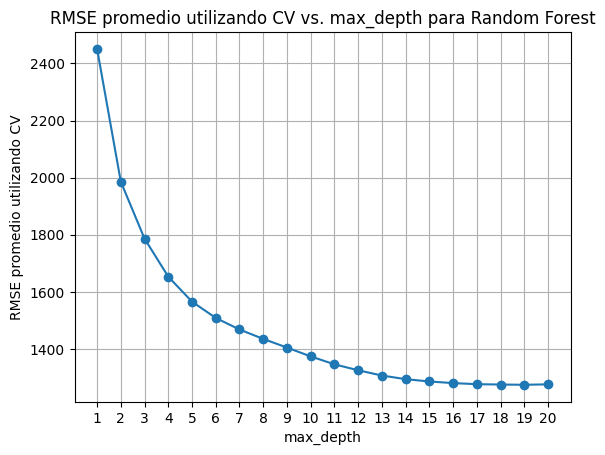

In [ ]:
# Celda 5

rmse_scores_cv = []

max_depth_range = range(1, 21)

for max_depth in max_depth_range:
    random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=max_depth, random_state=42)
    # Realizar cross-validation con 5 folds
    rmse_cv = -cross_val_score(random_forest_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
    rmse_scores_cv.append(rmse_cv)

# Encontrar el menor RMSE y su correspondiente max_depth
min_rmse_depth_cv = min(rmse_scores_cv)
best_max_depth_cv = max_depth_range[rmse_scores_cv.index(min_rmse_depth_cv)]

# Imprimir el resultado
print("El menor RMSE promedio utilizando CV es:", min_rmse_depth_cv)
print("Su correspondiente valor de max_depth es:", best_max_depth_cv)

plt.plot(max_depth_range, rmse_scores_cv, marker='o', linestyle='-')
plt.xlabel('max_depth')
plt.ylabel('RMSE promedio utilizando CV')
plt.title('RMSE promedio utilizando CV vs. max_depth para Random Forest')
plt.xticks(max_depth_range)
plt.grid(True)
plt.show()


# **Calibración de max_features**

El menor RMSE promedio utilizando CV es: 1270.4778071884346
Su respectivo valor de max_features es: 6


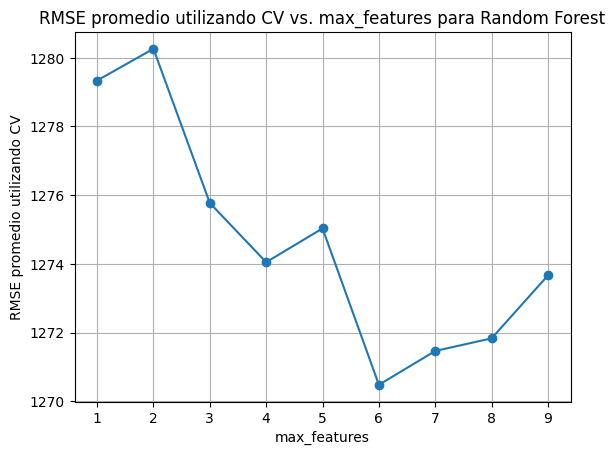

In [ ]:
# Lista para almacenar los resultados de RMSE promedio utilizando CV para diferentes valores de max_features
rmse_scores_mf_cv = []

# Rango de valores para max_features a probar
feature_cols = data.columns[data.columns != 'Price']
feature_range = range(1, len(feature_cols) + 1)

# Entrenar modelos con diferentes valores de max_features y calcular RMSE promedio utilizando CV
for max_features in feature_range:
    # Crear el modelo de Random Forest con el valor actual de max_features y best_max_depth_cv
    random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=best_max_depth_cv, max_features=max_features, random_state=42)

    # Calcular el RMSE promedio utilizando CV con 5 folds
    rmse_cv = -cross_val_score(random_forest_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

    # Agregar el RMSE promedio a la lista
    rmse_scores_mf_cv.append(rmse_cv)

# Encontrar el menor RMSE promedio y su respectivo max_features
min_rmse_cv = min(rmse_scores_mf_cv)
best_max_features_cv = feature_range[rmse_scores_mf_cv.index(min_rmse_cv)]

# Imprimir el resultado
print("El menor RMSE promedio utilizando CV es:", min_rmse_cv)
print("Su respectivo valor de max_features es:", best_max_features_cv)

# Graficar los resultados
plt.plot(feature_range, rmse_scores_mf_cv, marker='o', linestyle='-')
plt.xlabel('max_features')
plt.ylabel('RMSE promedio utilizando CV')
plt.title('RMSE promedio utilizando CV vs. max_features para Random Forest')
plt.xticks(feature_range)
plt.grid(True)
plt.show()


# **Calibración de n_estimators**

El mínimo RMSE promedio utilizando CV es: 1270.3598289118456
Corresponde a n_estimators = 110


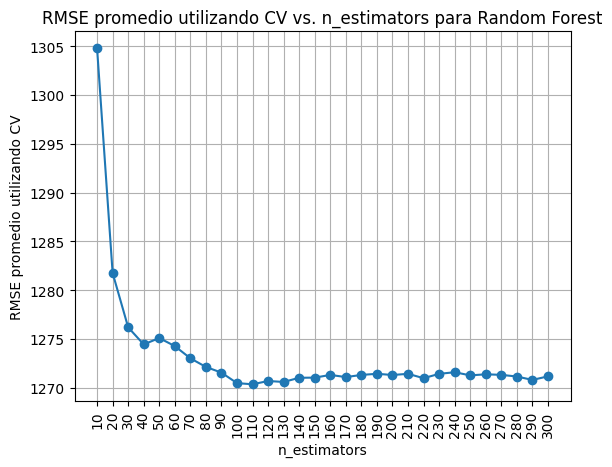

In [ ]:
# Lista para almacenar los resultados de RMSE promedio utilizando CV para diferentes valores de n_estimators
rmse_scores_cv = []

# Rango de valores para n_estimators a probar
n_estimators_range = range(10, 310, 10)

# Entrenar modelos con diferentes valores de n_estimators y calcular RMSE promedio utilizando CV
for n_estimators in n_estimators_range:
    # Crear el modelo de Random Forest con el valor actual de n_estimators, best_max_depth_cv y best_max_features_cv
    random_forest_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=best_max_depth_cv, max_features=best_max_features_cv, random_state=42)

    # Calcular el RMSE promedio utilizando CV con 5 folds
    rmse_cv = -cross_val_score(random_forest_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

    # Agregar el RMSE promedio a la lista
    rmse_scores_cv.append(rmse_cv)

# Encontrar el mínimo RMSE promedio y su respectivo n_estimators
min_rmse_cv = min(rmse_scores_cv)
n_estimators_optimo_cv = n_estimators_range[rmse_scores_cv.index(min_rmse_cv)]

# Imprimir el resultado
print("El mínimo RMSE promedio utilizando CV es:", min_rmse_cv)
print("Corresponde a n_estimators =", n_estimators_optimo_cv)

# Graficar los resultados
plt.plot(n_estimators_range, rmse_scores_cv, marker='o', linestyle='-')
plt.xlabel('n_estimators')
plt.ylabel('RMSE promedio utilizando CV')
plt.title('RMSE promedio utilizando CV vs. n_estimators para Random Forest')
plt.xticks(n_estimators_range, rotation=90)
plt.grid(True)
plt.show()


## **Implementación de un Random Forest con los mejores parámetros**

In [ ]:
# Crear el modelo de Random Forest con los hiperparámetros especificados
random_forest_model_cv = RandomForestRegressor(n_estimators=n_estimators_optimo_cv, max_depth=best_max_depth_cv, max_features=best_max_features_cv, random_state=42)

# Aplicar CV al modelo utilizando 5-fold cross-validation
cv_scores = cross_val_score(random_forest_model_cv, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Entrenar el modelo utilizando todos los datos de entrenamiento
random_forest_model_cv.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_rf_cv = random_forest_model_cv.predict(X_test)

# Calcular métricas de evaluación
rmse_rf_c_cv = np.sqrt(-cv_scores.mean())  # Usamos la media del negativo de los scores para obtener el RMSE
mae_rf_c_cv = mean_absolute_error(y_test, y_pred_rf_cv)

# Imprimir el desempeño del modelo
print("Desempeño del modelo de Random Forest con CV:")
print("RMSE:", rmse_rf_c_cv)
print("MAE:", mae_rf_c_cv)

Desempeño del modelo de Random Forest con CV:
RMSE: 1271.6932031685697
MAE: 965.1170702906762


**Desempeño del modelo Random Forest con mejores parámetros:** El modelo de Random Forest es notable, con un RMSE de 1271.69 y un MAE de 965.11, demostrando una capacidad sólida para predecir la variable objetivo con precisión. Al ajustar cada hiperparámetro, se observa cómo influyen en el rendimiento del modelo. Inicialmente, al variar la profundidad máxima de los árboles, se identifica el valor óptimo de max_depth como 19, lo que sugiere un equilibrio entre la complejidad del modelo y su capacidad para generalizar. Luego, al ajustar max_features, se encuentra que un valor de 6 minimiza aún más el RMSE, destacando la importancia de una selección cuidadosa de características para capturar la variabilidad en los datos. Por último, al ajustar n_estimators, se determina que 110 estimadores ofrecen el mejor desempeño, consolidando la estabilidad del modelo y mejorando su precisión predictiva. Además, al aplicar la validación cruzada, reforzamos la evaluación del modelo, garantizando una mayor confianza en su rendimiento consistente y confiable en futuras predicciones. Es crucial destacar que el valor óptimo de un hiperparámetro se utiliza como entrada para calibrar el siguiente, creando así un proceso iterativo de optimización. Una vez que todos los hiperparámetros están calibrados, se ensambla el modelo final con los valores óptimos, lo que garantiza un desempeño optimizado y confiable en la predicción de la variable objetivo.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 6
xgb_regressor = XGBRegressor(random_state = 1, cv = 5)
xgb_regressor

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, cv=5, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Entrenamiento Modelo XGBRegressor
xgb_regressor.fit(X_train, y_train)
y_pred_xgb = xgb_regressor.predict(X_test)

# Métricas del Modelo
rmse_xgboost = np.sqrt(metrics.mean_squared_error(y_pred_xgb, y_test.values))
mae_xgboost = metrics.mean_absolute_error(y_pred_xgb, y_test.values)

print(f'El RMSE del modelo XGBRegressor es {rmse_xgboost} \nEl MAE del modelo XGBRegressor es {mae_xgboost}')

El RMSE del modelo XGBRegressor es 1486.5326837665966 
El MAE del modelo XGBRegressor es 1075.289324260474


**Desempeño del modelo XGBoost**: El modelo de XGBoost estimado, muestra un rendimiento aceptable en la predicción de los valores objetivo. El error cuadrático medio (RMSE) es de 1486.53 y el error absoluto medio (MAE) es de 1075.29 indican que el modelo tiene cierta capacidad para predecir los valores.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

# **Calibración Learning Rate**

El menor RMSE es: 1483.914341126537
Su correspondiente valor de learning rate es: 0.11


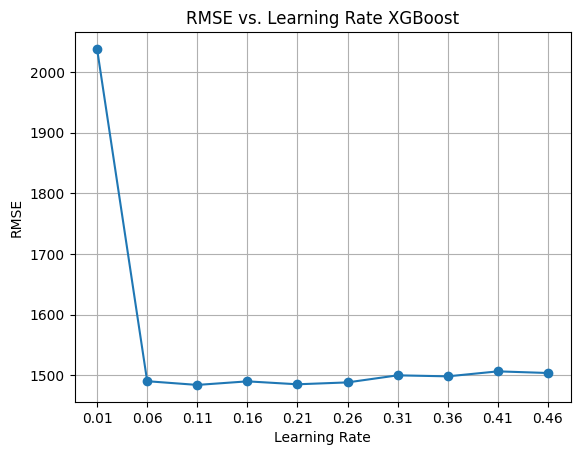

In [ ]:
# Celda 7
learning_range = np.arange(0.01, 0.5, 0.05)

# Definición de lista para almacenar RMSE
learning_rmse = []

for rate in learning_range:
    xgb_reg = XGBRegressor(learning_rate = rate, random_state=1, cv = 5)
    xgb_reg.fit(X_train, y_train)
    y_pred_xgbreg = xgb_reg.predict(X_test)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgbreg))
    learning_rmse.append(rmse_xgb)

# Encontrar el menor RMSE y su correspondiente learning_rate
min_rmse_learning = min(learning_rmse)
best_learning = learning_range[learning_rmse.index(min_rmse_learning)]

# Imprimir el resultado
print("El menor RMSE es:", min_rmse_learning)
print("Su correspondiente valor de learning rate es:", best_learning)

plt.plot(learning_range, learning_rmse, marker='o', linestyle='-')
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')
plt.title('RMSE vs. Learning Rate XGBoost')
plt.xticks(learning_range)
plt.grid(True)
plt.show()

# **Calibración Gamma**

El menor RMSE es: 1483.914341126537
Su correspondiente valor de Gamma es: 0.0


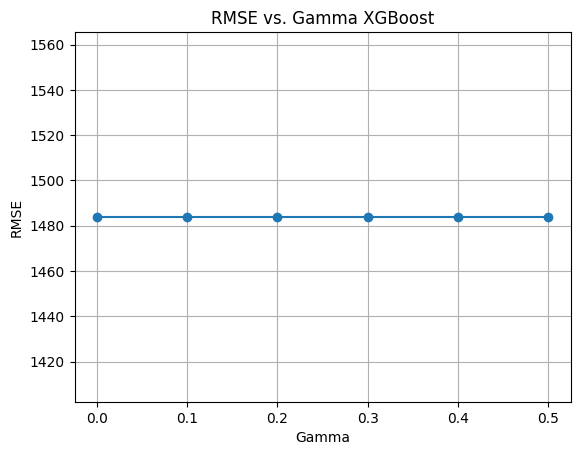

In [ ]:
gamma_range = np.arange(0, 0.6, 0.1)

# Definición de lista para almacenar RMSE
gamma_rmse = []

for i in gamma_range:
    xgb_reg = XGBRegressor(learning_rate = best_learning, gamma = i, random_state=1, cv = 5)
    xgb_reg.fit(X_train, y_train)
    y_pred_xgbreg = xgb_reg.predict(X_test)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgbreg))
    gamma_rmse.append(rmse_xgb)

# Encontrar el menor RMSE y su correspondiente Gamma
min_rmse_gamma = min(gamma_rmse)
best_gamma = gamma_range[gamma_rmse.index(min_rmse_gamma)]

# Imprimir el resultado
print("El menor RMSE es:", min_rmse_gamma)
print("Su correspondiente valor de Gamma es:", best_gamma)

plt.plot(gamma_range, gamma_rmse, marker='o', linestyle='-')
plt.xlabel('Gamma')
plt.ylabel('RMSE')
plt.title('RMSE vs. Gamma XGBoost')
plt.xticks(gamma_range)
plt.grid(True)
plt.show()

# **Calibración colsample_bytree**

El menor RMSE es: 1487.6541977894562
Su correspondiente valor de colsample_bytree es: 0.9000000000000001


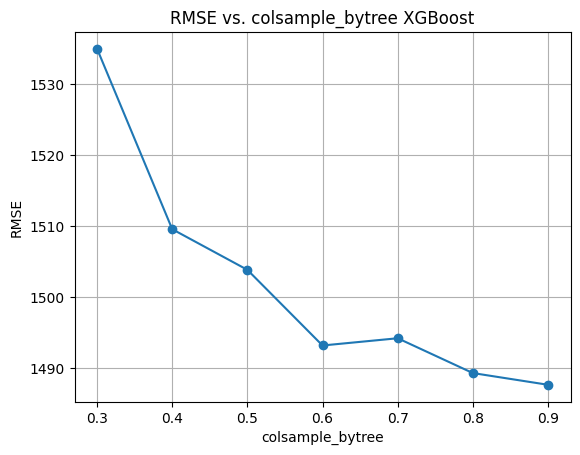

In [ ]:
colsample_range = np.arange(0.3, 0.9, 0.1)

# Definición de lista para almacenar RMSE
colsample_rmse = []

for sample in colsample_range:
    xgb_reg = XGBRegressor(learning_rate = best_learning, gamma = best_gamma, colsample_bytree = sample, random_state=1, cv = 5)
    xgb_reg.fit(X_train, y_train)
    y_pred_xgbreg = xgb_reg.predict(X_test)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgbreg))
    colsample_rmse.append(rmse_xgb)

# Encontrar el menor RMSE y su correspondiente colsample_bytree
min_rmse_colsample = min(colsample_rmse)
best_colsample = colsample_range[colsample_rmse.index(min_rmse_colsample)]

# Imprimir el resultado
print("El menor RMSE es:", min_rmse_colsample)
print("Su correspondiente valor de colsample_bytree es:", best_colsample)

plt.plot(colsample_range, colsample_rmse, marker='o', linestyle='-')
plt.xlabel('colsample_bytree')
plt.ylabel('RMSE')
plt.title('RMSE vs. colsample_bytree XGBoost')
plt.xticks(colsample_range)
plt.grid(True)
plt.show()

# **Implementación XGBoost con los mejores parámetros**

In [ ]:
xgb_regressor_cal = XGBRegressor(random_state = 1, cv = 5, learning_rate = best_learning, gamma = best_gamma, colsample_bytree = best_colsample )

# Entrenamiento Modelo XGBRegressor
xgb_regressor_cal.fit(X_train, y_train)
y_pred_xgbcal = xgb_regressor_cal.predict(X_test)

# Métricas del Modelo
rmse_xgboostcal = np.sqrt(metrics.mean_squared_error(y_pred_xgbcal, y_test.values))
mae_xgboostcal = metrics.mean_absolute_error(y_pred_xgbcal, y_test.values)

print(f'El RMSE del modelo XGBRegressor es {rmse_xgboostcal} \nEl MAE del modelo XGBRegressor es {mae_xgboostcal}')


El RMSE del modelo XGBRegressor es 1487.6541977894562 
El MAE del modelo XGBRegressor es 1085.7059402289622


# **Calibración Parámetros con Grid Search**


In [ ]:

# Calibración con la estrategia de validación cruzada Grid Search
# Parámetros para aplicar Grid Search
grid_search_params = {
'colsample_bytree': [0.3, 0.5, 0.9],
'learning_rate': [0.01, 0.06, 0.11, 0.2],
  'gamma': [0, 0.1, 0.2, 0.3]}
grid = GridSearchCV(estimator=xgb_regressor, param_grid=grid_search_params, scoring='neg_mean_squared_error', cv=4, verbose=1)
grid.fit(X_train, y_train)
print("GridSearchCV")
print("Mejores parámetros encontrados: ", grid.best_params_)

Fitting 4 folds for each of 48 candidates, totalling 192 fits
GridSearchCV
Mejores parámetros encontrados:  {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.2}


In [ ]:
xgb_regr_grid = XGBRegressor(colsample_bytree=grid.best_params_['colsample_bytree'],
                             learning_rate=grid.best_params_['learning_rate'],
                             gamma=grid.best_params_['gamma'], random_state = 1)
xgb_regr_grid.fit(X_train, y_train)
y_pred = xgb_regr_grid.predict(X_test)

# Métricas del Modelo
rmse_xgboost_grid = np.sqrt(metrics.mean_squared_error(y_pred, y_test.values))
mae_xgboost_grid = metrics.mean_absolute_error(y_pred, y_test.values)
print('El RMSE del modelo XGBRegressor calibrado con Grid search es:', rmse_xgboost_grid)
print('El MAE del modelo XGBRegressor calibrado con Grid search es:', mae_xgboost_grid)

El RMSE del modelo XGBRegressor calibrado con Grid search es: 1480.8737209980452
El MAE del modelo XGBRegressor calibrado con Grid search es: 1078.1213065977736


**Desempeño del modelo XGBoost con calibración manual:** Comparando las métricas obtenidas con el modelo calibrado respecto al modelo XGBoost sin calibrar, se aprecia que no hubo mejora, por el contrario se tuvo un RMSE ligeramente mayor.

**Efectos de los parámetros en el desempeño del modelo:** El parámetro learning rate presenta un impacto importante en el RMSE al aumentar su valor, a partir de 0.01, punto en el cual la mencionada métrica presenta un valor por encima de 2000. Desde el valor 0.06 en adelante, los resultados del RMSE oscilan sobre 1500, logrando el menor RMSE en 0.11. Para el caso del parámetro gamma, se aprecia que la evaluación de la variación de este parámetro en el rango establecido (de 0 a 0.6) no generó ningún efecto en el RMSE. Finalmente, el parámetro colsample_bytree en la medida que aumenta, causa una reducción del RMSE, logrando el mejor desempeño del sistema con un valor de 0.9.

Se ha considerado también en este punto aplicar el procedimiento de calibración empleando el método de Grid Search de la biblioteca scikit_learn sobre las mismas 3 variables. Con este procedimiento se logró un mejor RMSE y MAE que lo obtenido con los modelos sin calibrar y con calibración manual. Los valores óptimos para los parámetros analizados por este método son: learning rate = 0.2, colsample_bytree = 0.9, gamma = 0.


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

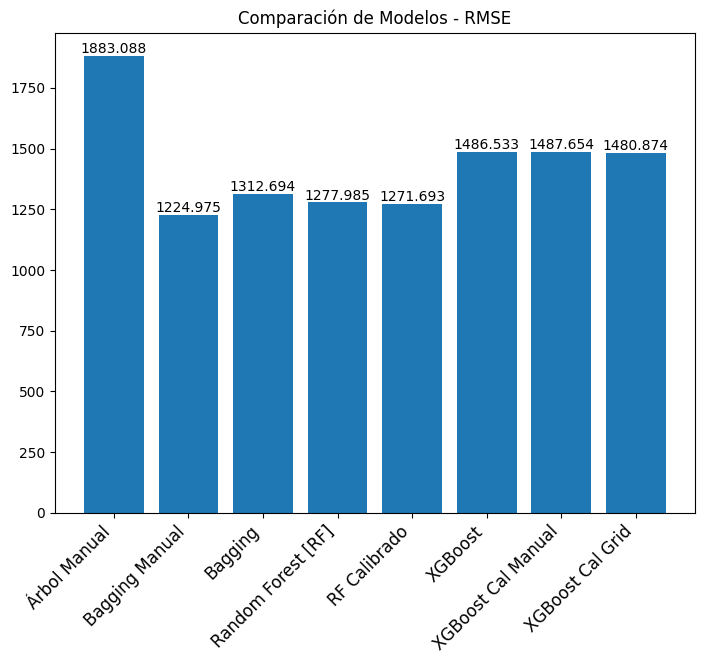

In [ ]:
# Celda 8

# RMSE
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de Modelos - RMSE")
ejeX = ['Árbol Manual','Bagging Manual', 'Bagging', 'Random Forest [RF]', 'RF Calibrado', 'XGBoost', 'XGBoost Cal Manual', 'XGBoost Cal Grid']
ejeY = [round(rmse_ArbMan,3), round(rmse_baggingman,3), round(rmse_bagging_cv,3), round(rmse_rf_cv,3), round(rmse_rf_c_cv,3), round(rmse_xgboost,3), round(rmse_xgboostcal,3), round(rmse_xgboost_grid,3)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i], ha='center', va='bottom', fontsize=10)
addlabels(ejeX,ejeY,plt)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.show()

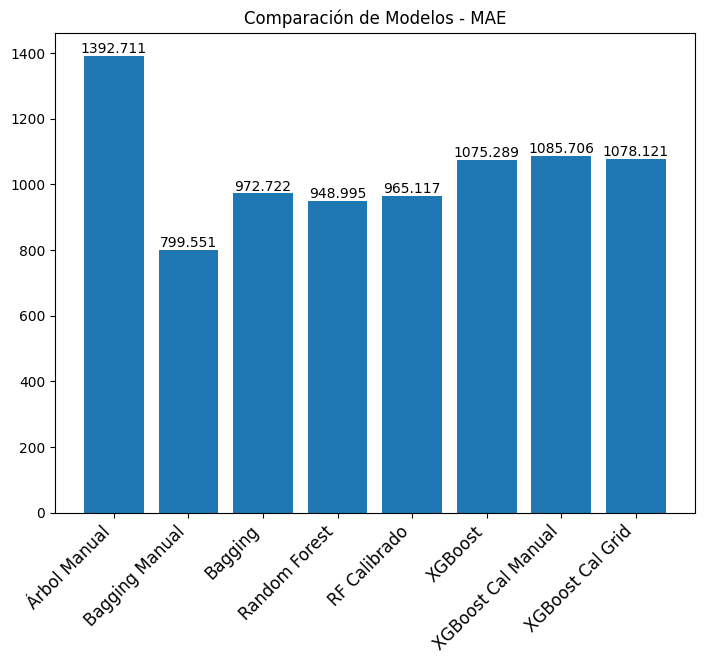

In [ ]:
# MAE
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de Modelos - MAE")
ejeX = ['Árbol Manual','Bagging Manual', 'Bagging', 'Random Forest', 'RF Calibrado', 'XGBoost', 'XGBoost Cal Manual', 'XGBoost Cal Grid']
ejeY = [round(mae_ArbMan,3), round(mae_baggingman,3), round(mae_bagging_cv,3), round(mae_rf_cv,3), round(mae_rf_c_cv,3), round(mae_xgboost,3), round(mae_xgboostcal,3), round(mae_xgboost_grid,3)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i], ha='center', va='bottom', fontsize=10)
addlabels(ejeX,ejeY,plt)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.show()


El modelo que destacó por su mejor desempeño fue el Bagging Manual con un MSE de 1224.975 y un MAE de 799.551 y el que peor rendimiento presentó fue el árbol de decisión manual con un MSE de 1883.088 y un MAE de 1392.711. Sin embargo, al enfocarnos en comparar los modelos Random Forest y XGBoost, observamos que el Random Forest Calibrado mostró el mejor desempeño con un RMSE de 1271.693 y un MAE de 965.117, destacándose por una mayor certeza en las estimaciones y una mejor consideración de la importancia de las variables predictoras. En comparación, XGBoost obtuvo un RMSE de 1486.533 y un MAE de 1075.289 presentando una sensibilidad a los hiperparámetros y una menor interpretabilidad,